In [1]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [2]:
%load_ext autoreload
%autoreload 2
%pylab inline

from functools import partial
from tqdm import tqdm
import pickle
from chainconsumer import ChainConsumer

import jax
import jax.numpy as jnp
jnp.ones([1,2])


import haiku as hk
from haiku._src.nets.resnet import ResNet18
import optax

from sbi_lens.normflow.models import AffineSigmoidCoupling, ConditionalRealNVP
from sbi_lens.gen_dataset.lensing_lognormal_dataset import LensingLogNormalDataset
import pickle
'unset XLA_FLAGS'


import jax_cosmo as jc
from sbi_lens.simulator.redshift import subdivide

Populating the interactive namespace from numpy and matplotlib


/linkhome/rech/genmfd01/ulm75uc/.local/lib/python3.10/site-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
2023-05-04 16:35:07.957891: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/gpfslocalsup/pub/anaconda-py3/2021.05/envs/python-3.10.4/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "
/linkhome/rech/genmfd01/ulm75uc/.local/lib/python3.10/site-packages/lenstools/utils/mpi.py:15: UserWarning: Could not import mpi4py! (if you set sys.modules['mpi4py']=None please disregard this message)
  warnings.warn(wmsg)


In [3]:
import logging


import tensorflow_probability as tfp; tfp = tfp.substrates.jax

# this prints a WARNING

tfp.distributions.TransformedDistribution(
    tfp.distributions.Normal(0.0, 1.0), tfp.bijectors.Identity()
)

logger = logging.getLogger("root")


class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()


logger.addFilter(CheckTypesFilter())

# this does not print a WARNING

tfp.distributions.TransformedDistribution(
    tfp.distributions.Normal(0.0, 1.0), tfp.bijectors.Identity()
)

<tfp.distributions.TransformedDistribution 'identityNormal' batch_shape=[] event_shape=[] dtype=float32>

# Dataset

In [4]:
tfd= tfp.distributions
tfb = tfp.bijectors
import tensorflow_datasets as tfds
import tensorflow as tf

In [5]:
def augmentation_with_noise(example):

      N=256
      map_size=10
      gal_per_arcmin2=27
      sigma_e=0.26
      pix_area = (map_size * 60 / N)**2 
      a=2
      b=0.68
      z0=0.11
      nbins=5
        
      nz = jc.redshift.smail_nz(a, b, z0, gals_per_arcmin2=gal_per_arcmin2)
      nz_bins = subdivide(nz, nbins=nbins, zphot_sigma=0.05)
      x = example['simulation']
      x += tf.random.normal(
        shape=(N, N, 5),
        stddev=sigma_e / tf.math.sqrt(
          jnp.array([b.gals_per_arcmin2 for b in nz_bins]) * pix_area
        )
      )
      x = tf.image.random_flip_left_right(x)
      x = tf.image.random_flip_up_down(x)

      return {'simulation': x, 'theta': example['theta'], 'score': example['score']}

In [6]:
# dataset
ds = tfds.load('LensingLogNormalDataset/year_10_without_noise_score_density', 
               split='train[:80000]', 
               data_dir = 'tensorflow_dataset')

ds = ds.repeat()
ds = ds.shuffle(1000)
ds = ds.map(augmentation_with_noise)
ds = ds.batch(128)
ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
ds_train = iter(tfds.as_numpy(ds))


2023-05-04 16:35:21.758659: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Import parameters compressor

In [7]:
bijector_layers_compressor = [128] * 2

bijector_compressor = partial(
  AffineSigmoidCoupling, 
  layers=bijector_layers_compressor, 
  activation=jax.nn.silu
)

NF_compressor = partial(
  ConditionalRealNVP, 
  n_layers=4, 
  bijector_fn=bijector_compressor
)

class Flow_nd_Compressor(hk.Module):
    def __call__(self, y):
        nvp = NF_compressor(6)(y)
        return nvp

nf = hk.without_apply_rng(
    hk.transform(
        lambda theta, y : Flow_nd_Compressor()(y).log_prob(theta).squeeze()
    )
)


compressor = hk.transform_with_state(lambda x : ResNet18(6)(x, is_training=False))


In [8]:
Train='vmim'

In [9]:
with open("/gpfsdswork/projects/rech/ykz/ulm75uc/sbi_lens/sbi_lens/data/params_compressor/params_nd_compressor_{}.pkl".format(Train), 'rb') as f:
    parameters_compressor = pickle.load(f)
##################################################
with open("/gpfsdswork/projects/rech/ykz/ulm75uc/sbi_lens/sbi_lens/data/params_compressor/opt_state_resnet_{}.pkl".format(Train), 'rb') as g:
    opt_state_resnet = pickle.load(g)

/linkhome/rech/genmfd01/ulm75uc/.local/lib/python3.10/site-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)


In [10]:
prior = tfd.MultivariateNormalDiag(jnp.array([0.2664,0.0492,0.831,0.6727,0.9645,-1.0]), jnp.array([0.2,0.006,0.14,0.063,0.08,0.9])*jnp.ones(6))
theta = prior.sample(10000,jax.random.PRNGKey(0))
scale_theta = (jnp.std(theta, axis = 0)/0.06)
shift_theta = jnp.mean(theta/scale_theta, axis = 0)-0.5

## Create NF for SBI

In [11]:
bijector_layers = [128] * 2

bijector_npe = partial(
  AffineSigmoidCoupling, 
  layers=bijector_layers, 
  n_components=16, 
  activation=jax.nn.silu
)

NF_npe = partial(
    
  ConditionalRealNVP, 
  n_layers=4, 
  bijector_fn=bijector_npe
)

class SmoothNPE(hk.Module):
    def __call__(self, y):
        net = y
        nvp = NF_npe(6)(net)
        nf = tfd.TransformedDistribution(
            nvp,
            tfb.Chain([tfb.Scale(scale_theta),tfb.Shift(shift_theta)])
        )
        return nf


In [12]:
nvp_nd = hk.without_apply_rng(hk.transform(lambda theta,y : SmoothNPE()(y).log_prob(theta).squeeze()))
params_nd = nvp_nd.init(jax.random.PRNGKey(42), 0.5*jnp.ones([1,6]), 0.5*jnp.ones([1,6]))

/linkhome/rech/genmfd01/ulm75uc/.local/lib/python3.10/site-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)


In [13]:

#optimizer
total_steps = 3000
lr_scheduler = optax.piecewise_constant_schedule(
    init_value=0.001,
    boundaries_and_scales={int(total_steps*0.2):0.7,
                           int(total_steps*0.4):0.7,
                           int(total_steps*0.6):0.7,
                           int(total_steps*0.8):0.7}
)

optimizer = optax.adam(learning_rate=lr_scheduler)
opt_state_nd = optimizer.init(params_nd)


In [14]:
from sbi_lens.normflow.train_model import TrainModel

model = TrainModel(
        compressor = compressor,
        nf = nvp_nd,
        optimizer = optimizer,
        loss_name = 'loss_for_sbi', 
        nb_pixels = 256, 
        nb_bins = 5, 
        info_compressor=[parameters_compressor, opt_state_resnet]
)

update = jax.jit(model.update)

## Training

In [15]:

batch_loss=[]
for batch in tqdm(range(total_steps)):
    samples = next(ds_train)
    if not jnp.isnan(samples['simulation']).any():
        l, params_nd, opt_state_nd, opt_state_resnet=update(
            model_params = params_nd, 
            opt_state=opt_state_nd,
            ##################
            theta = samples['theta'],
            x=samples['simulation']
        )

        batch_loss.append(l)
        if jnp.isnan(l):
          print('NaN Loss')
          break

  0%|          | 0/3000 [00:00<?, ?it/s]/linkhome/rech/genmfd01/ulm75uc/.local/lib/python3.10/site-packages/haiku/_src/data_structures.py:206: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, structure = jax.tree_flatten(mapping)
/linkhome/rech/genmfd01/ulm75uc/.local/lib/python3.10/site-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)
100%|██████████| 3000/3000 [1:01:22<00:00,  1.23s/it]


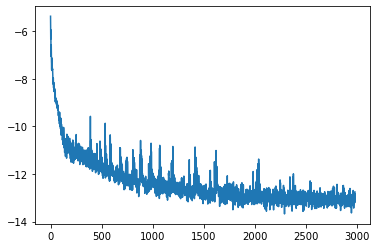

In [16]:
plt.plot(batch_loss)

In [17]:
m_data = np.load("/gpfsdswork/projects/rech/ykz/ulm75uc/VMIM-vs-MSE-/data/m_data__256N_10ms_27gpa_026se.npy")

y, _ = compressor.apply(
   parameters_compressor, opt_state_resnet, None, m_data.reshape([1,256,256,5])
)
nvp_sample_nd = hk.transform(
    lambda x : SmoothNPE()(x).sample(1000000, seed=hk.next_rng_key())
)
tfd= tfp.distributions
tfb = tfp.bijectors
sample_nd = nvp_sample_nd.apply(
    params_nd, 
    rng = jax.random.PRNGKey(43), 
    x = y*jnp.ones([1000000,6])
)

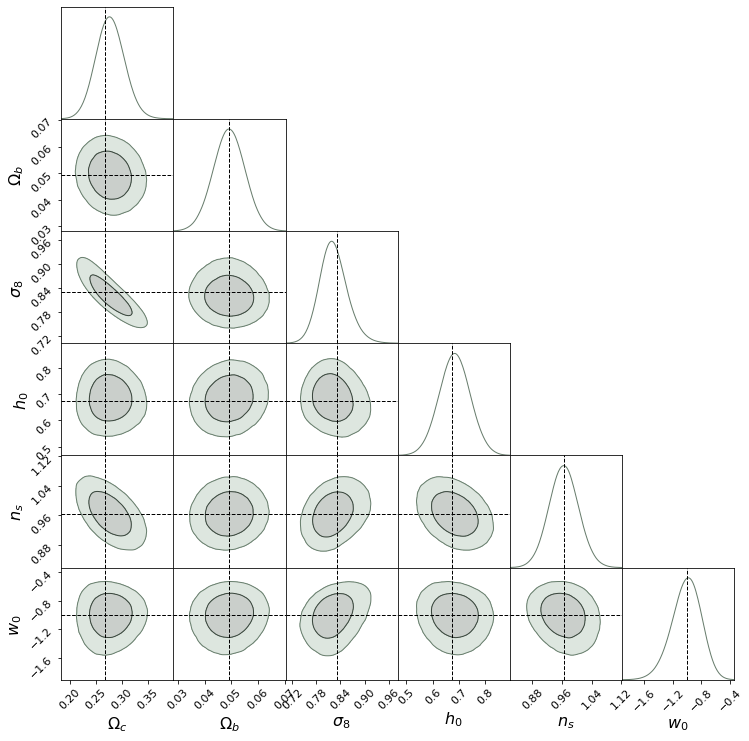

In [18]:
name_parameters= ['$\Omega_c$', '$\Omega_b$', '$\sigma_8$', '$h_0$', '$n_s$', '$w_0$']
import cmasher as cmr
col = cmr.eclipse([0.,0,0.55,0.85]) 
fid_params=np.array([0.2664, 0.0492, 0.831,0.6727,0.9645, -1.0])

c = ChainConsumer()
c.add_chain([sample_nd[:,i] for i in range(6)], parameters= name_parameters, name = 'SBI')
c.configure(usetex=False,legend_kwargs={'fontsize': 20},linewidths=[1.], shade=[True],linestyles=["-"], shade_alpha=[0.3], bar_shade=[False], tick_font_size=11, colors=[col[2]], label_font_size=16)
fig = c.plotter.plot(truth=fid_params)
fig.set_size_inches(2 + fig.get_size_inches())


In [19]:

with open("params_nd_{}.pkl".format(Train), "wb") as fp:
  pickle.dump(params_nd, fp)

with open("opt_state_nd_{}.pkl".format(Train), "wb") as fp:
  pickle.dump(opt_state_nd, fp)

with open("sample_nd_{}.pkl".format(Train), "wb") as fp:
  pickle.dump(sample_nd, fp)


/linkhome/rech/genmfd01/ulm75uc/.local/lib/python3.10/site-packages/haiku/_src/data_structures.py:214: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  self._mapping = jax.tree_unflatten(self._structure, self._leaves)
